In [ ]:
# GENYZ TEAM
# Aleta Edna Jessalyn 
# Angelina Wahyuni 
# Keisya Andretta
# Infall Syafalni

# reusing the nmos and pmos primitives from gLayout

In [1]:
import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file,path,scale = 3):
  
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg(os.path.join(path,'out.svg'))
    
  # Scale the image for displaying
  fig = sg.fromfile(os.path.join(path,'out.svg'))
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save(os.path.join(path,'out.svg'))

  # Display the image
  IPython.display.display(IPython.display.SVG(os.path.join(path,'out.svg')))
  os.remove(os.path.join(path,'out.gds'))

def display_component(component,path,scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds(os.path.join(path,'out.gds'))
  display_gds(os.path.join(path,'out.gds'),path,scale)

from glayout import MappedPDK, sky130 , gf180
from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../TGSW"))

from my_TGSW import tgswitch

2025-09-18 20:02:06.636 | INFO     | gdsfactory.pdk:activate:337 - 'gf180' PDK is now active
2025-09-18 20:02:34.646 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.4.1", "klayout_version": "0.30.2", "type": "open", "file": "/tmp/gdsfactory/chopper_switch.gds"}


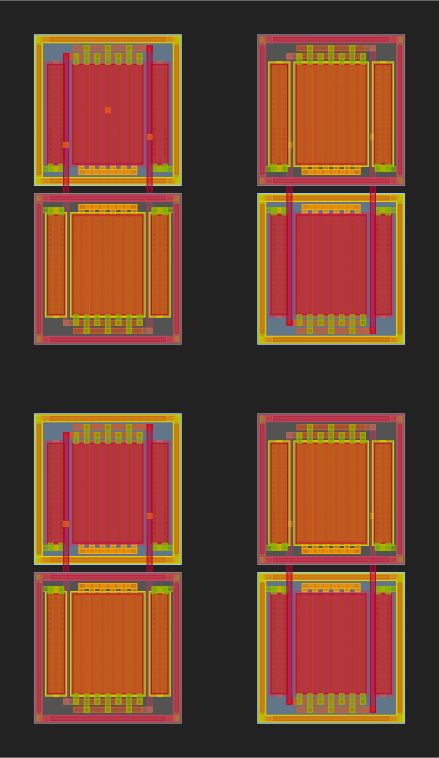

In [2]:
chopper_switch_config={
        "pdk": gf180, # pdk to use
        "placement" : "vertical", # the two fets can be placed either vertically or horizontally
        "width": (10,10), # width of the input fet and feedback fet respectively.
        "length": (0.5,0.5), # length of the input fet and feedback fet respectively. None refers to the min length in the pdk.
        "fingers": (6,6), # no. of fingers of the input fet and feedback fet respectively.
        "multipliers": (1,1), #no. of multipliers of the input fet and feedback fet respectively.
        "dummy_1": (True,True), # dummy pattern for input fet (left,right)
        "dummy_2": (True,True), # dummy pattern for the feedback fet (left,right)
        "tie_layers1": ("met2","met1"), #tapring metal layers for output fet
        "tie_layers2": ("met2","met1"), #tapring metal layers for output fet
        "sd_rmult":1, # thickness of the sd metal layer.
}
top_level = Component(name="chopper_switch")
pdk=chopper_switch_config["pdk"]
pdk.activate()

width=chopper_switch_config["width"]
length=chopper_switch_config["length"]
fingers=chopper_switch_config["fingers"]
multipliers=chopper_switch_config["multipliers"]

dummy_1=chopper_switch_config["dummy_1"]
dummy_2=chopper_switch_config["dummy_2"]
tie_layers1=chopper_switch_config["tie_layers1"]
tie_layers2=chopper_switch_config["tie_layers2"]
sd_rmult=chopper_switch_config["sd_rmult"]

SW1 = tgswitch(pdk, "vertical",(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))
SW2 = tgswitch(pdk, "vertical_inv",(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))
SW1_ref = top_level << SW1

x_distance = 15
y_distance = 14.5
ref_dimensions = evaluate_bbox(SW1_ref)

SW2_ref = top_level << SW2
SW3 = tgswitch(pdk, "vertical",(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))
SW4 = tgswitch(pdk, "vertical_inv",(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))
SW3_ref = top_level << SW3
SW4_ref = top_level << SW4

SW1_ref.name = "SW1"
SW2_ref.name = "SW2"
SW3_ref.name = "SW3"
SW4_ref.name = "SW4"

SW2_ref.movex(SW1_ref.xmax + x_distance)
SW3_ref.movey(SW1_ref.ymin - y_distance)
SW4_ref.movex(SW1_ref.xmax + x_distance).movey(SW1_ref.ymin - y_distance)

viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.

#via for input and output
vinp_start_via = top_level << viam2m3
vinp_end_via = top_level << viam2m3
vinn_start_via = top_level << viam2m3
vinn_end_via = top_level << viam2m3

voutp_start_via = top_level << viam2m3
voutp_end_via = top_level << viam2m3
voutn_start_via = top_level << viam2m3
voutn_end_via = top_level << viam2m3

#via for CLK and CLKinv
clk_top_via = top_level << viam2m3
clk_bottom_via = top_level << viam2m3
clkinv_top_via = top_level << viam2m3
clkinv_bottom_via = top_level << viam2m3

top_level.show()
display_component(top_level, scale = 1,path="../../")

/headless/conda-env/miniconda3/envs/GLdev/lib/python3.10/site-packages/gdsfactory/show.py:40: UserWarning: Unnamed cells, 1 in 'chopper_switch'
  gdspath = component.write_gds(
2025-09-18 20:02:37.979 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.4.1", "klayout_version": "0.30.2", "type": "reload", "file": "/tmp/gdsfactory/chopper_switch.gds"}


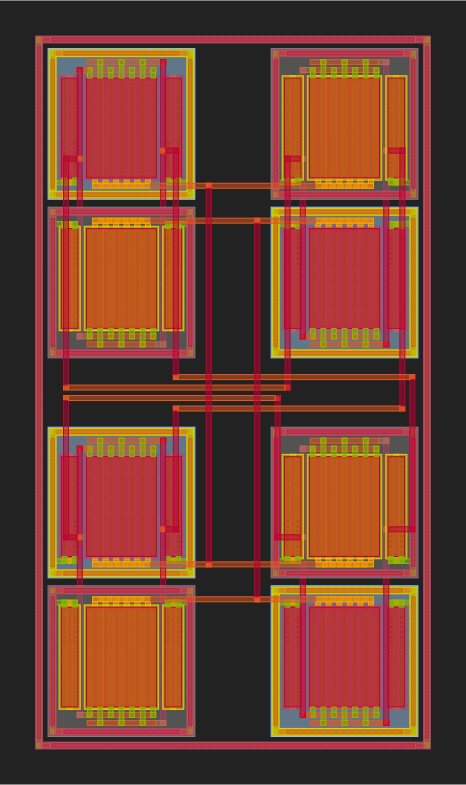

In [3]:
top_level << straight_route(pdk, SW1_ref.ports["P_gate_E"], SW2_ref.ports["N_gate_W"])
top_level << straight_route(pdk, SW1_ref.ports["N_gate_E"], SW2_ref.ports["P_gate_W"])
top_level << straight_route(pdk, SW3_ref.ports["P_gate_E"], SW4_ref.ports["N_gate_W"])
top_level << straight_route(pdk, SW3_ref.ports["N_gate_E"], SW4_ref.ports["P_gate_W"])

vinp_start_via.move(SW1_ref.ports["P_source_top_met_W"].center).movey(SW1_ref.ymin - pdk.util_max_metal_seperation()).movex(-ref_dimensions[0]/1.55)
vinn_start_via.move(vinp_start_via.center).movey(- 0.75 - pdk.util_max_metal_seperation())
vinp_end_via.move(vinp_start_via.center).movex(SW2_ref.xmax - x_distance/2)
vinn_end_via.move(vinn_start_via.center).movex(SW2_ref.xmax - x_distance/2 - 1)

voutp_start_via.move(vinp_start_via.center).movey(pdk.util_max_metal_seperation()+0.75).movex(SW2_ref.xmin - 4)
voutn_start_via.move(vinn_start_via.center).movey(-pdk.util_max_metal_seperation()-0.75).movex(SW2_ref.xmin - 4)
voutp_end_via.move(voutp_start_via.center).movex(SW2_ref.xmax-6)
voutn_end_via.move(voutn_start_via.center).movex(SW2_ref.xmax-7)

clk_top_via.move(SW1_ref.ports["P_gate_E"].center).movex(SW1_ref.xmax-1.5)
clkinv_top_via.move(SW2_ref.ports["P_gate_W"].center).movex(SW1_ref.xmin+1.5)
clk_bottom_via.move(SW3_ref.ports["P_gate_E"].center).movex(SW1_ref.xmax-1.5)
clkinv_bottom_via.move(SW4_ref.ports["P_gate_W"].center).movex(SW1_ref.xmin+1.5)

#input routes
top_level << L_route(pdk, SW1_ref.ports["P_drain_top_met_W"], vinp_start_via.ports["top_met_N"])
top_level << L_route(pdk, SW3_ref.ports["P_drain_top_met_W"], vinn_start_via.ports["top_met_S"])
top_level << L_route(pdk, SW4_ref.ports["P_drain_top_met_W"], vinn_end_via.ports["top_met_N"])
top_level << L_route(pdk, SW2_ref.ports["P_drain_top_met_W"], vinp_end_via.ports["top_met_S"])
top_level << straight_route(pdk, vinp_start_via.ports["bottom_met_E"], vinp_end_via.ports["bottom_met_W"])
top_level << straight_route(pdk, vinn_start_via.ports["bottom_met_E"], vinn_end_via.ports["bottom_met_W"])

#output routes
top_level << L_route(pdk, SW1_ref.ports["P_source_top_met_E"], voutp_start_via.ports["top_met_N"])
top_level << L_route(pdk, SW3_ref.ports["P_source_top_met_E"], voutn_start_via.ports["top_met_S"])
top_level << L_route(pdk, SW2_ref.ports["P_source_top_met_E"], voutn_end_via.ports["top_met_N"])
top_level << L_route(pdk, SW4_ref.ports["P_source_top_met_E"], voutp_end_via.ports["top_met_S"])
top_level << straight_route(pdk, voutp_start_via.ports["bottom_met_E"], voutp_end_via.ports["bottom_met_W"])
top_level << straight_route(pdk, voutn_start_via.ports["bottom_met_E"], voutn_end_via.ports["bottom_met_W"])

#CLK routes
top_level << straight_route(pdk, clk_top_via.ports["top_met_S"], clk_bottom_via.ports["top_met_N"])
top_level << straight_route(pdk, clkinv_top_via.ports["top_met_S"], clkinv_bottom_via.ports["top_met_N"])

# Add tapring
tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]+pdk.util_max_metal_seperation()))
shift_amount = -prec_center(top_level.flatten())[0]
shifty_amount = prec_center(top_level.flatten())[1]
tring_ref = top_level << tap_ring
tring_ref.movex(destination=shift_amount).movey(destination=-shifty_amount)

# Add metal route from SW to Tapring
#top_level << straight_route(pdk, SW3_ref["N_tie_E_top_met_E"], tap_ring.ports["E_top_met_W"])
top_level.show()
display_component(top_level, scale = 1,path="../../")

2025-09-18 20:02:39.292 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.4.1", "klayout_version": "0.30.2", "type": "reload", "file": "/tmp/gdsfactory/chopper_switch.gds"}


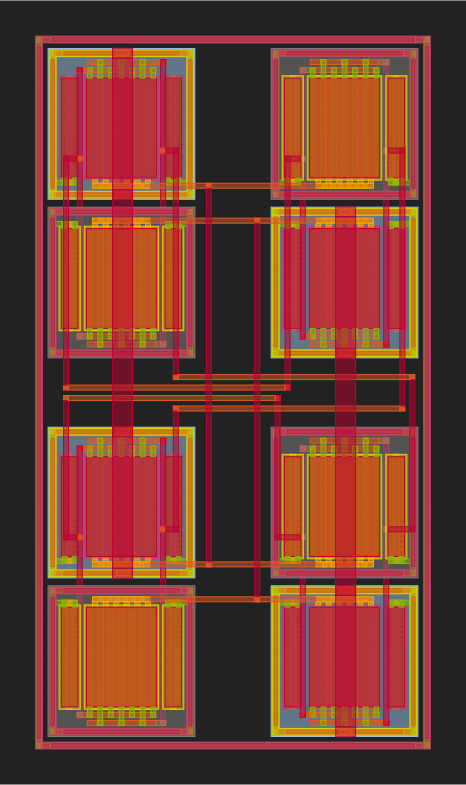

In [4]:
#VDD Rails
viaarray = via_array(pdk, "met2", "met3", (2,1)) 

VDD1_via = top_level << viaarray
VDD2_via = top_level << viaarray
VDD3_via = top_level << viaarray
VDD4_via = top_level << viaarray
VDD5_via = top_level << viaarray
VDD6_via = top_level << viaarray
VDD7_via = top_level << viaarray
VDD8_via = top_level << viaarray

VDD1_via.move(SW1_ref.ports["P_tie_N_top_met_E"].center).movex(SW1_ref.xmin+0.75)
VDD2_via.move(SW1_ref.ports["P_tie_S_top_met_E"].center).movex(SW1_ref.xmin+0.75)
VDD3_via.move(SW2_ref.ports["P_tie_N_top_met_E"].center).movex(SW1_ref.xmin+0.75)
VDD4_via.move(SW2_ref.ports["P_tie_S_top_met_E"].center).movex(SW1_ref.xmin+0.75)
VDD5_via.move(SW3_ref.ports["P_tie_N_top_met_E"].center).movex(SW1_ref.xmin+0.75)
VDD6_via.move(SW3_ref.ports["P_tie_S_top_met_E"].center).movex(SW1_ref.xmin+0.75)
VDD7_via.move(SW4_ref.ports["P_tie_N_top_met_E"].center).movex(SW1_ref.xmin+0.75)
VDD8_via.move(SW4_ref.ports["P_tie_S_top_met_E"].center).movex(SW1_ref.xmin+0.75)

top_level << straight_route(pdk, VDD1_via.ports["top_met_S"], VDD6_via.ports["top_met_N"])
top_level << straight_route(pdk, VDD4_via.ports["top_met_S"], VDD7_via.ports["top_met_N"])

top_level.show()
display_component(top_level, scale = 1,path="../../")

2025-09-18 20:02:40.973 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.4.1", "klayout_version": "0.30.2", "type": "reload", "file": "/tmp/gdsfactory/chopper_switch.gds"}


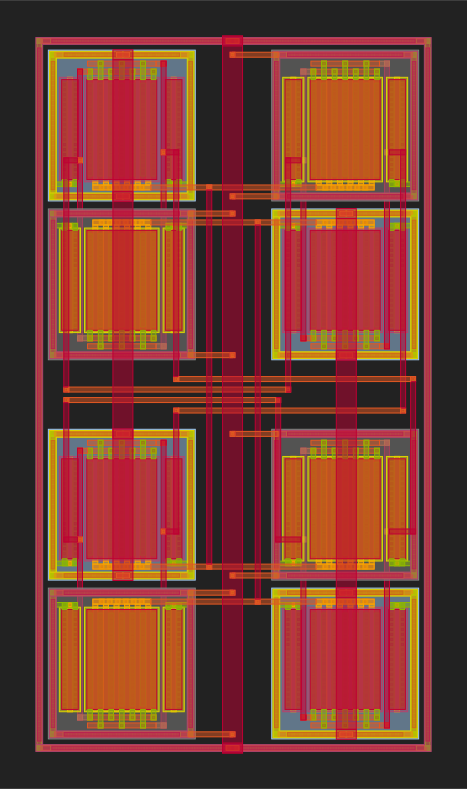

In [5]:
# VSS Rails

VSS1_via = top_level << viaarray
VSS2_via = top_level << viaarray
VSS1_via.move(tring_ref.ports["N_top_met_E"].center).movex(tring_ref.xmin*2.25)
VSS2_via.move(tring_ref.ports["S_top_met_E"].center).movex(tring_ref.xmin*2.25)

top_level << straight_route(pdk, VSS1_via.ports["top_met_N"], VSS2_via.ports["top_met_S"], width=2)

top_level << straight_route(pdk, SW2_ref.ports["N_tie_N_top_met_W"], VSS1_via.ports["top_met_N"])
top_level << straight_route(pdk, SW2_ref.ports["N_tie_S_top_met_W"], VSS1_via.ports["top_met_N"])
top_level << straight_route(pdk, SW1_ref.ports["N_tie_N_top_met_E"], VSS1_via.ports["top_met_N"])
top_level << straight_route(pdk, SW1_ref.ports["N_tie_S_top_met_E"], VSS1_via.ports["top_met_N"])
top_level << straight_route(pdk, SW4_ref.ports["N_tie_N_top_met_W"], VSS1_via.ports["top_met_N"])
top_level << straight_route(pdk, SW4_ref.ports["N_tie_S_top_met_W"], VSS1_via.ports["top_met_N"])
top_level << straight_route(pdk, SW3_ref.ports["N_tie_N_top_met_E"], VSS1_via.ports["top_met_N"])
top_level << straight_route(pdk, SW3_ref.ports["N_tie_S_top_met_E"], VSS1_via.ports["top_met_N"])

top_level.show()
display_component(top_level, scale = 1,path="../../")

/headless/conda-env/miniconda3/envs/GLdev/lib/python3.10/site-packages/gdsfactory/show.py:40: UserWarning: Unnamed cells, 1 in 'Unnamed_47fbe6df'
  gdspath = component.write_gds(
2025-09-18 20:02:44.157 | INFO     | gdsfactory.klive:show:55 - Message from klive: {"version": "0.4.1", "klayout_version": "0.30.2", "type": "open", "file": "/tmp/gdsfactory/Unnamed_47fbe6df.gds"}


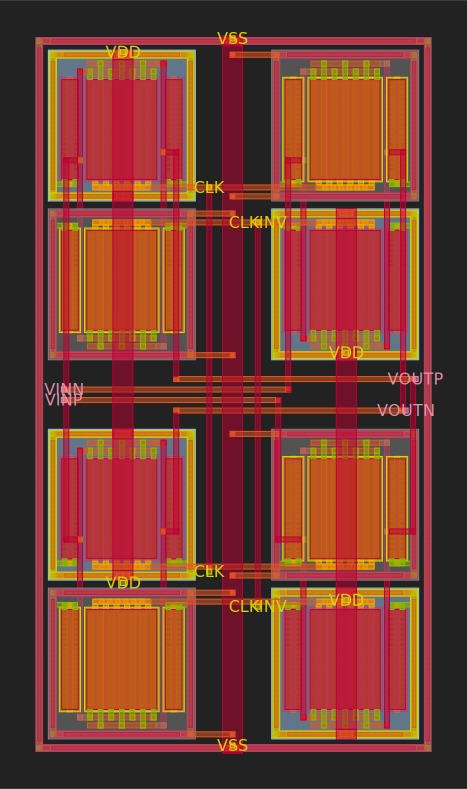

In [6]:
top_level.add_ports(SW1_ref.get_ports_list(), prefix="SW1_")
top_level.add_ports(SW2_ref.get_ports_list(), prefix="SW2_")
top_level.add_ports(SW3_ref.get_ports_list(), prefix="SW3_")
top_level.add_ports(SW4_ref.get_ports_list(), prefix="SW4_")

top_level.add_ports(vinp_start_via.get_ports_list(), prefix="INP_")
top_level.add_ports(vinn_start_via.get_ports_list(), prefix="INN_")
top_level.add_ports(voutp_end_via.get_ports_list(), prefix="OUTP_")
top_level.add_ports(voutn_end_via.get_ports_list(), prefix="OUTN_")

top_level.add_ports(clk_top_via.get_ports_list(), prefix="CLK_TOP_")
top_level.add_ports(clkinv_top_via.get_ports_list(), prefix="CLKINV_TOP_")
top_level.add_ports(clk_bottom_via.get_ports_list(), prefix="CLK_BOTTOM_")
top_level.add_ports(clkinv_bottom_via.get_ports_list(), prefix="CLKINV_BOTTOM_")

top_level.add_ports(VDD1_via.get_ports_list(), prefix="VDD_TOPL_")
top_level.add_ports(VDD3_via.get_ports_list(), prefix="VDD_TOPR_")
top_level.add_ports(VDD6_via.get_ports_list(), prefix="VDD_BOTTOML_")
top_level.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")

top_level.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOP_")
top_level.add_ports(VSS2_via.get_ports_list(), prefix="VSS_BOTTOM_")

component = component_snap_to_grid(rename_ports_by_orientation(top_level))
    
# Now that our block is complete, let's see how it looks now!!
#component.show()
#display_component(component, scale = 1,path="../../")
#component.show()
##inv_gds = component.write_gds("inv.gds")

## To see all Ports
# component.pprint_ports()

## To see selected ports
# for s in component.get_ports_list():
#     if len(s.name.split("_")) <4:
#         if set(["P","gate"]).issubset(set(s.name.split("_"))):
#             print(s.name, s.port_type , s.orientation, s.center, s.width, s.layer)

psize=(0.5,0.5)
# list that will contain all port/comp info
move_info = list()
# create labels and append to info list

# VSS
vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
move_info.append((vsslabel,component.ports["VSS_TOP_top_met_N"],None))
move_info.append((vsslabel,component.ports["VSS_BOTTOM_top_met_N"],None))
#gnd_ref = top_level << gndlabel;

#suply
vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
move_info.append((vddlabel,component.ports["VDD_TOPL_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_TOPR_top_met_N"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOML_top_met_S"],None))
move_info.append((vddlabel,component.ports["VDD_BOTTOMR_top_met_S"],None))
#sup_ref = top_level << suplabel;


# output
outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputplabel,component.ports["OUTP_top_met_E"],None))
outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
move_info.append((outputnlabel,component.ports["OUTN_top_met_E"],None))
#op_ref = top_level << outputlabel;

# input
inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputplabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputplabel,component.ports["INP_top_met_W"], None))
inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
inputnlabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
move_info.append((inputnlabel,component.ports["INN_top_met_W"], None))
#ip_ref = top_level << inputlabel;

# CLK
clklabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clklabel.add_label(text="CLK",layer=pdk.get_glayer("met3_pin"))
move_info.append((clklabel,component.ports["CLK_TOP_top_met_N"], None))
move_info.append((clklabel,component.ports["CLK_BOTTOM_top_met_S"], None))
clkinvlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
clkinvlabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
move_info.append((clkinvlabel,component.ports["CLKINV_TOP_top_met_N"], None))
move_info.append((clkinvlabel,component.ports["CLKINV_BOTTOM_top_met_S"], None))
#clk_ref = top_level << clklabel;

for comp, prt, alignment in move_info:
        alignment = ('c','b') if alignment is None else alignment
        compref = align_comp_to_port(comp, prt, alignment=alignment)
        top_level.add(compref)
component = top_level.flatten()

component.show()
display_component(top_level, scale =1,path="../../")

In [33]:
comps = top_level.flatten()
comps.name="cswitch"
drc_result = gf180.drc_magic(comps, comps.name)

2025-09-05 13:19:39.238 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to '/tmp/tmpsvvb6hl4/cswitch$3.gds'


using default pdk_root
Defaulting to stale magic_commands.tcl

Magic 8.3 revision 528 - Compiled on Wed Jun 18 09:45:25 PM CEST 2025.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Processing system .magicrc file
Sourcing design .magicrc for technology gf180mcuD ...
10 Magic internal units = 1 Lambda
Input style import: scaleFactor=10, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3 m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment 
Scaled tech values by 10 / 1 to match internal grid scaling
Loading gf180mcuD Device Generator Menu ...
Loading "/tmp/tmpsvvb6hl4/magic_commands.tcl" from command line.
Library written using GDS-II Release 6.0
Library name: library
Reading "cswitch$3".
[INFO]: Loading cswitch$3

Loading DRC CIF style.
No err

In [36]:
comps.write_gds("CSA1.gds")

2025-09-05 14:08:22.330 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'CSA1.gds'


PosixPath('CSA1.gds')

In [35]:
inv_code_string = """
from glayout import MappedPDK, sky130 , gf180
#from gdsfactory.cell import cell
from gdsfactory import Component
from gdsfactory.components import text_freetype, rectangle
from glayout import nmos, pmos
from glayout import via_stack, via_array
from glayout import rename_ports_by_orientation
from glayout import tapring
from glayout.util.comp_utils import evaluate_bbox, prec_center, prec_ref_center, align_comp_to_port
from glayout.util.port_utils import add_ports_perimeter,print_ports
from glayout.util.snap_to_grid import component_snap_to_grid
from glayout.spice.netlist import Netlist
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from glayout.routing.L_route import L_route

import os
import subprocess

# Run a shell, source .bashrc, then printenv
cmd = 'bash -c "source ~/.bashrc && printenv"'
result = subprocess.run(cmd, shell=True, text=True, capture_output=True)
env_vars = {}
for line in result.stdout.splitlines():
    if '=' in line:
        key, value = line.split('=', 1)
        env_vars[key] = value

# Now, update os.environ with these
os.environ.update(env_vars)

import sys
from pathlib import Path
sys.path.append(os.path.abspath("../../TGSW"))

from my_TGSW import tgswitch

def add_cswitch_labels(
    cswitch_in: Component,
    pdk: MappedPDK,
    ) -> Component:
    
    cswitch_in.unlock()

    psize=(0.5,0.5)
    # list that will contain all port/comp info
    move_info = list()
    # create labels and append to info list

    # VSS
    vsslabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vsslabel.add_label(text="VSS",layer=pdk.get_glayer("met3_label"))
    move_info.append((vsslabel,cswitch_in.ports["VSS_TOP_top_met_N"],None))
    move_info.append((vsslabel,cswitch_in.ports["VSS_BOTTOM_top_met_N"],None))
    #gnd_ref = top_level << gndlabel;

    #suply
    vddlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    vddlabel.add_label(text="VDD",layer=pdk.get_glayer("met3_pin"))
    move_info.append((vddlabel,cswitch_in.ports["VDD_TOPL_top_met_N"],None))
    move_info.append((vddlabel,cswitch_in.ports["VDD_TOPR_top_met_N"],None))
    move_info.append((vddlabel,cswitch_in.ports["VDD_BOTTOML_top_met_S"],None))
    move_info.append((vddlabel,cswitch_in.ports["VDD_BOTTOMR_top_met_S"],None))
    #sup_ref = top_level << suplabel;

    # output
    outputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputplabel.add_label(text="VOUTP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputplabel,cswitch_in.ports["OUTP_top_met_E"],None))
    outputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    outputnlabel.add_label(text="VOUTN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((outputnlabel,cswitch_in.ports["OUTN_top_met_E"],None))
    #op_ref = top_level << outputlabel;

    # input
    inputplabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputplabel.add_label(text="VINN",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputplabel,component.ports["INP_top_met_W"], None))
    inputnlabel = rectangle(layer=pdk.get_glayer("met2_pin"),size=psize,centered=True).copy()
    inputnlabel.add_label(text="VINP",layer=pdk.get_glayer("met2_pin"))
    move_info.append((inputnlabel,component.ports["INN_top_met_W"], None))
    #ip_ref = top_level << inputlabel;

    # CLK
    clklabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clklabel.add_label(text="CLK",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clklabel,cswitch_in.ports["CLK_TOP_top_met_N"], None))
    move_info.append((clklabel,cswitch_in.ports["CLK_BOTTOM_top_met_S"], None))
    clkinvlabel = rectangle(layer=pdk.get_glayer("met3_pin"),size=psize,centered=True).copy()
    clkinvlabel.add_label(text="CLKINV",layer=pdk.get_glayer("met3_pin"))
    move_info.append((clkinvlabel,cswitch_in.ports["CLKINV_TOP_top_met_N"], None))
    move_info.append((clkinvlabel,cswitch_in.ports["CLKINV_BOTTOM_top_met_S"], None))
    #clk_ref = top_level << clklabel;

    for comp, prt, alignment in move_info:
            alignment = ('c','b') if alignment is None else alignment
            compref = align_comp_to_port(comp, prt, alignment=alignment)
            cswitch_in.add(compref)
    
    return cswitch_in.flatten()

def cswitch(
        pdk: MappedPDK,
        width: tuple[float,float] = (10,10),
        length: tuple[float,float] = (0.5,0.5),
        fingers: tuple[int,int] = (6,6),
        multipliers: tuple[int,int] = (1,1),
        dummy_1: tuple[bool,bool] = (True,True),
        dummy_2: tuple[bool,bool] = (True,True),
        tie_layers1: tuple[str,str] = ("met2","met1"),
        tie_layers2: tuple[str,str] = ("met2","met1"),
        sd_rmult: int=1,
        **kwargs
        ) -> Component:

    pdk.activate()
    
    #top level component
    top_level = Component(name="cswitch")

    #four TG Switch
    SW1 = tgswitch(pdk, "vertical",(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))
    SW2 = tgswitch(pdk, "vertical_inv",(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))
    SW3 = tgswitch(pdk, "vertical",(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))
    SW4 = tgswitch(pdk, "vertical_inv",(width[0],width[1]),(length[0],length[1]),(fingers[0],fingers[1]),(multipliers[0],multipliers[1]))

    SW1_ref = top_level << SW1
    SW2_ref = top_level << SW2
    SW3_ref = top_level << SW3
    SW4_ref = top_level << SW4

    SW1_ref.name = "SW1"
    SW2_ref.name = "SW2"
    SW3_ref.name = "SW3"
    SW4_ref.name = "SW4"

    x_distance = 15
    y_distance = 14.5
    ref_dimensions = evaluate_bbox(SW1_ref)

    SW2_ref.movex(SW1_ref.xmax + x_distance)
    SW3_ref.movey(SW1_ref.ymin - y_distance)
    SW4_ref.movex(SW1_ref.xmax + x_distance).movey(SW1_ref.ymin - y_distance)

    viam2m3 = via_stack(pdk, "met2", "met3", centered=True) #met2 is the bottom layer. met3 is the top layer.

    #via for input and output
    vinp_start_via = top_level << viam2m3
    vinp_end_via = top_level << viam2m3
    vinn_start_via = top_level << viam2m3
    vinn_end_via = top_level << viam2m3

    voutp_start_via = top_level << viam2m3
    voutp_end_via = top_level << viam2m3
    voutn_start_via = top_level << viam2m3
    voutn_end_via = top_level << viam2m3

    #via for CLK and CLKinv
    clk_top_via = top_level << viam2m3
    clk_bottom_via = top_level << viam2m3
    clkinv_top_via = top_level << viam2m3
    clkinv_bottom_via = top_level << viam2m3


    top_level << straight_route(pdk, SW1_ref.ports["P_gate_E"], SW2_ref.ports["N_gate_W"])
    top_level << straight_route(pdk, SW1_ref.ports["N_gate_E"], SW2_ref.ports["P_gate_W"])
    top_level << straight_route(pdk, SW3_ref.ports["P_gate_E"], SW4_ref.ports["N_gate_W"])
    top_level << straight_route(pdk, SW3_ref.ports["N_gate_E"], SW4_ref.ports["P_gate_W"])

    vinp_start_via.move(SW1_ref.ports["P_source_top_met_W"].center).movey(SW1_ref.ymin - pdk.util_max_metal_seperation()).movex(-ref_dimensions[0]/1.55)
    vinn_start_via.move(vinp_start_via.center).movey(- 0.75 - pdk.util_max_metal_seperation())
    vinp_end_via.move(vinp_start_via.center).movex(SW2_ref.xmax - x_distance/2)
    vinn_end_via.move(vinn_start_via.center).movex(SW2_ref.xmax - x_distance/2 - 1)

    voutp_start_via.move(vinp_start_via.center).movey(pdk.util_max_metal_seperation()+0.75).movex(SW2_ref.xmin - 4)
    voutn_start_via.move(vinn_start_via.center).movey(-pdk.util_max_metal_seperation()-0.75).movex(SW2_ref.xmin - 4)
    voutp_end_via.move(voutp_start_via.center).movex(SW2_ref.xmax-6)
    voutn_end_via.move(voutn_start_via.center).movex(SW2_ref.xmax-7)

    clk_top_via.move(SW1_ref.ports["P_gate_E"].center).movex(SW1_ref.xmax-1.5)
    clkinv_top_via.move(SW2_ref.ports["P_gate_W"].center).movex(SW1_ref.xmin+1.5)
    clk_bottom_via.move(SW3_ref.ports["P_gate_E"].center).movex(SW1_ref.xmax-1.5)
    clkinv_bottom_via.move(SW4_ref.ports["P_gate_W"].center).movex(SW1_ref.xmin+1.5)

    #input routes
    top_level << L_route(pdk, SW1_ref.ports["P_drain_top_met_W"], vinp_start_via.ports["top_met_N"])
    top_level << L_route(pdk, SW3_ref.ports["P_drain_top_met_W"], vinn_start_via.ports["top_met_S"])
    top_level << L_route(pdk, SW4_ref.ports["P_drain_top_met_W"], vinn_end_via.ports["top_met_N"])
    top_level << L_route(pdk, SW2_ref.ports["P_drain_top_met_W"], vinp_end_via.ports["top_met_S"])
    top_level << straight_route(pdk, vinp_start_via.ports["bottom_met_E"], vinp_end_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, vinn_start_via.ports["bottom_met_E"], vinn_end_via.ports["bottom_met_W"])

    #output routes
    top_level << L_route(pdk, SW1_ref.ports["P_source_top_met_E"], voutp_start_via.ports["top_met_N"])
    top_level << L_route(pdk, SW3_ref.ports["P_source_top_met_E"], voutn_start_via.ports["top_met_S"])
    top_level << L_route(pdk, SW2_ref.ports["P_source_top_met_E"], voutn_end_via.ports["top_met_N"])
    top_level << L_route(pdk, SW4_ref.ports["P_source_top_met_E"], voutp_end_via.ports["top_met_S"])
    top_level << straight_route(pdk, voutp_start_via.ports["bottom_met_E"], voutp_end_via.ports["bottom_met_W"])
    top_level << straight_route(pdk, voutn_start_via.ports["bottom_met_E"], voutn_end_via.ports["bottom_met_W"])

    #CLK routes
    top_level << straight_route(pdk, clk_top_via.ports["top_met_S"], clk_bottom_via.ports["top_met_N"])
    top_level << straight_route(pdk, clkinv_top_via.ports["top_met_S"], clkinv_bottom_via.ports["top_met_N"])

    # Add tapring
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(top_level.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]+pdk.util_max_metal_seperation()))
    shift_amount = -prec_center(top_level.flatten())[0]
    shifty_amount = prec_center(top_level.flatten())[1]
    tring_ref = top_level << tap_ring
    tring_ref.movex(destination=shift_amount).movey(destination=-shifty_amount)

    #VDD Rails
    viaarray = via_array(pdk, "met2", "met3", (2,1)) 

    VDD1_via = top_level << viaarray
    VDD2_via = top_level << viaarray
    VDD3_via = top_level << viaarray
    VDD4_via = top_level << viaarray
    VDD5_via = top_level << viaarray
    VDD6_via = top_level << viaarray
    VDD7_via = top_level << viaarray
    VDD8_via = top_level << viaarray

    VDD1_via.move(SW1_ref.ports["P_tie_N_top_met_E"].center).movex(SW1_ref.xmin+0.75)
    VDD2_via.move(SW1_ref.ports["P_tie_S_top_met_E"].center).movex(SW1_ref.xmin+0.75)
    VDD3_via.move(SW2_ref.ports["P_tie_N_top_met_E"].center).movex(SW1_ref.xmin+0.75)
    VDD4_via.move(SW2_ref.ports["P_tie_S_top_met_E"].center).movex(SW1_ref.xmin+0.75)
    VDD5_via.move(SW3_ref.ports["P_tie_N_top_met_E"].center).movex(SW1_ref.xmin+0.75)
    VDD6_via.move(SW3_ref.ports["P_tie_S_top_met_E"].center).movex(SW1_ref.xmin+0.75)
    VDD7_via.move(SW4_ref.ports["P_tie_N_top_met_E"].center).movex(SW1_ref.xmin+0.75)
    VDD8_via.move(SW4_ref.ports["P_tie_S_top_met_E"].center).movex(SW1_ref.xmin+0.75)

    top_level << straight_route(pdk, VDD1_via.ports["top_met_S"], VDD6_via.ports["top_met_N"])
    top_level << straight_route(pdk, VDD4_via.ports["top_met_S"], VDD7_via.ports["top_met_N"])
    
    # VSS Rails
    VSS1_via = top_level << viaarray
    VSS2_via = top_level << viaarray
    VSS1_via.move(tring_ref.ports["N_top_met_E"].center).movex(tring_ref.xmin*2.25)
    VSS2_via.move(tring_ref.ports["S_top_met_E"].center).movex(tring_ref.xmin*2.25)

    top_level << straight_route(pdk, VSS1_via.ports["top_met_N"], VSS2_via.ports["top_met_S"], width=2)

    top_level << straight_route(pdk, SW2_ref.ports["N_tie_N_top_met_W"], VSS1_via.ports["top_met_N"])
    top_level << straight_route(pdk, SW2_ref.ports["N_tie_S_top_met_W"], VSS1_via.ports["top_met_N"])
    top_level << straight_route(pdk, SW1_ref.ports["N_tie_N_top_met_E"], VSS1_via.ports["top_met_N"])
    top_level << straight_route(pdk, SW1_ref.ports["N_tie_S_top_met_E"], VSS1_via.ports["top_met_N"])
    top_level << straight_route(pdk, SW4_ref.ports["N_tie_N_top_met_W"], VSS1_via.ports["top_met_N"])
    top_level << straight_route(pdk, SW4_ref.ports["N_tie_S_top_met_W"], VSS1_via.ports["top_met_N"])
    top_level << straight_route(pdk, SW3_ref.ports["N_tie_N_top_met_E"], VSS1_via.ports["top_met_N"])
    top_level << straight_route(pdk, SW3_ref.ports["N_tie_S_top_met_E"], VSS1_via.ports["top_met_N"])
    
    top_level.add_ports(SW1_ref.get_ports_list(), prefix="SW1_")
    top_level.add_ports(SW2_ref.get_ports_list(), prefix="SW2_")
    top_level.add_ports(SW3_ref.get_ports_list(), prefix="SW3_")
    top_level.add_ports(SW4_ref.get_ports_list(), prefix="SW4_")

    top_level.add_ports(vinp_start_via.get_ports_list(), prefix="INP_")
    top_level.add_ports(vinn_start_via.get_ports_list(), prefix="INN_")
    top_level.add_ports(voutp_end_via.get_ports_list(), prefix="OUTP_")
    top_level.add_ports(voutn_end_via.get_ports_list(), prefix="OUTN_")

    top_level.add_ports(clk_top_via.get_ports_list(), prefix="CLK_TOP_")
    top_level.add_ports(clkinv_top_via.get_ports_list(), prefix="CLKINV_TOP_")
    top_level.add_ports(clk_bottom_via.get_ports_list(), prefix="CLK_BOTTOM_")
    top_level.add_ports(clkinv_bottom_via.get_ports_list(), prefix="CLKINV_BOTTOM_")

    top_level.add_ports(VDD1_via.get_ports_list(), prefix="VDD_TOPL_")
    top_level.add_ports(VDD3_via.get_ports_list(), prefix="VDD_TOPR_")
    top_level.add_ports(VDD6_via.get_ports_list(), prefix="VDD_BOTTOML_")
    top_level.add_ports(VDD8_via.get_ports_list(), prefix="VDD_BOTTOMR_")

    top_level.add_ports(VSS1_via.get_ports_list(), prefix="VSS_TOP_")
    top_level.add_ports(VSS2_via.get_ports_list(), prefix="VSS_BOTTOM_")

    return component_snap_to_grid(rename_ports_by_orientation(top_level))

if __name__ == "__main__":
\tcomp = cswitch(gf180)\n
\t# comp.pprint_ports()\n
\tcomp = add_cswitch_labels(comp, gf180)\n
\tcomp.name = "CSWITCH"\n
\tcomp.write_gds('out_CSWITCH.gds')\n
\tcomp.show()\n
\tprint("...Running DRC...")\n
\tdrc_result = gf180.drc_magic(comp, "CSWITCH")\n
\tdrc_result = gf180.drc(comp)\n
"""

inv_init_string = """
###Glayout CSWITCH Cell.


from .my_CSWITCH import cswitch,add_cswitch_labels

__all__ = [
    'cswitch',
    'add_cswitch_labels',
] 
"""

directory = "../../CSWITCH/"
os.makedirs(directory, exist_ok=True)

# Save to a .py file
with open(directory + "my_CSWITCH.py", "w") as file:
    file.write(inv_code_string)

with open(directory + "__init__.py", "w") as file:
    file.write(inv_init_string)